# Testing procedure for 1D pendulum

In [31]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 3
np.set_printoptions(precision=5, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create training and testing signals

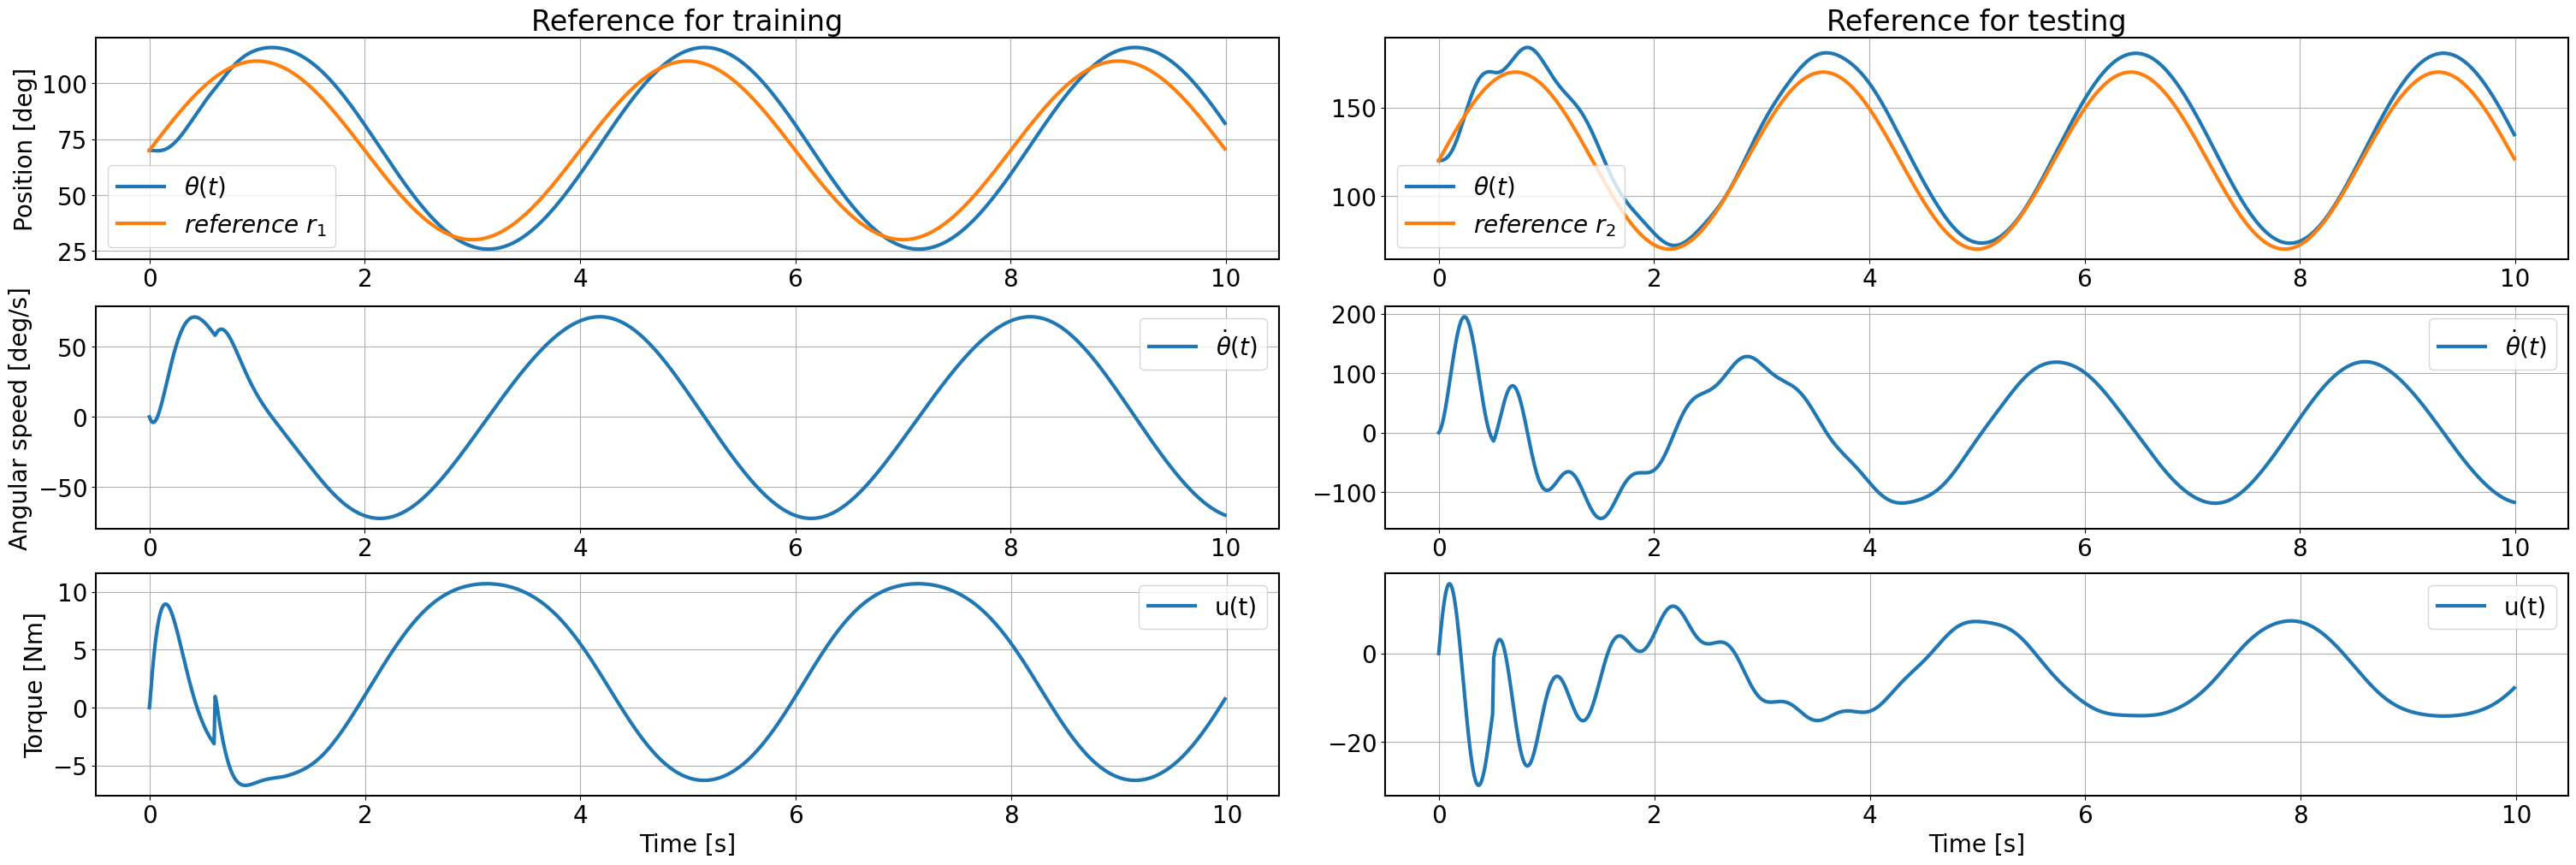

In [116]:
# Pendulum instance
dt = 1e-2
time = np.arange(0,10,dt)
pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(70),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(120),0]), dt=dt)

# Controller design
K, Ki, Kd, t_max = 10, 50, 0, 12

# Reference design
freq1, freq2 = .25, .35
pend1.T_ref, pend2.T_ref = 1/freq1/pend1.dt, 1/freq2/pend2.dt
amplitude1, amplitude2 = 40, 50 # deg
pend1.ref = sineReference(pend1.N, pend1.dt, pend1.T_ref, amplitude1, 70)
# pend1.ref = sineReference(pend1.N, pend1.dt, [], [], offset=60, varying=True, freq_vector=[.4], amp_vector=[30])
# pend1.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(0),deg2rad(90)], np.int(pend1.T_ref/10), 0)
pend2.ref = sineReference(pend2.N, pend1.dt, pend2.T_ref, amplitude2, 120)
# pend2.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(50),deg2rad(130)], np.int(pend1.T_ref/10), 0)
u1 = lambda i: 5 + 2.5*np.sin(2*np.pi/pend1.T_ref*i)
u2 = lambda i: 5 + 1.5*np.cos(2*np.pi/pend2.T_ref*i)

# Simulation

integral = 0
for i in range(pend1.N-1):
    if i <= pend1.N:
        Kp, Ki, Kd = 80, 5, 10
    else:
        Kp, Ki, Kd = 20, 2.5, 5
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 60, limit=30, integral=integral)[0]
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 150, 3, 15, pend2.dt, 50, limit=20)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,0].plot(pend1.T, rad2deg(np.array(pend1.ref)), label=r"$reference \ r_1$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend2.T, rad2deg(np.array(pend2.ref)), label=r"$reference \ r_2$")
ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()
ax[0,0].set_title('Reference for training'), ax[0,1].set_title('Reference for testing')

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend2.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_ylabel('Angular speed [deg/s]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

ax[2,0].plot(pend1.T[:pend1.N-1], pend1.U, label='u(t)')
ax[2,1].plot(pend2.T[:pend1.N-1], pend2.U, label='u(t)')
ax[2,0].set_xlabel('Time [s]'), ax[2,0].set_ylabel('Torque [Nm]'), ax[2,1].set_xlabel('Time [s]')
ax[2,0].grid(), ax[2,1].grid()
ax[2,0].legend(), ax[2,1].legend()

fig.savefig('Images/Pend_id_sine.svg',format='svg',dpi=800)

Text(0.5, 1.0, 'Singular values of the Hankel matrix SVD')

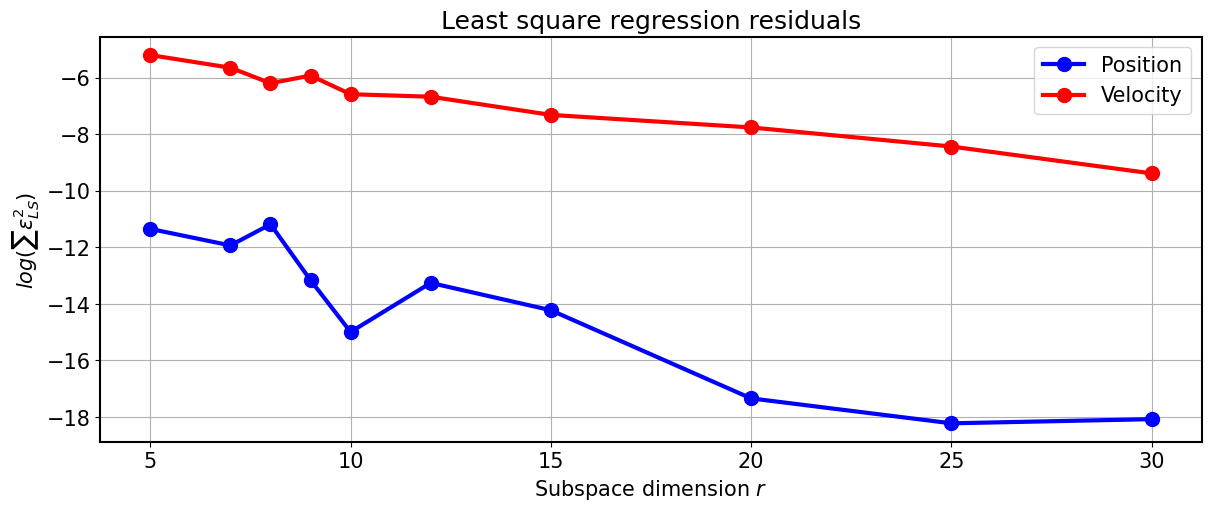

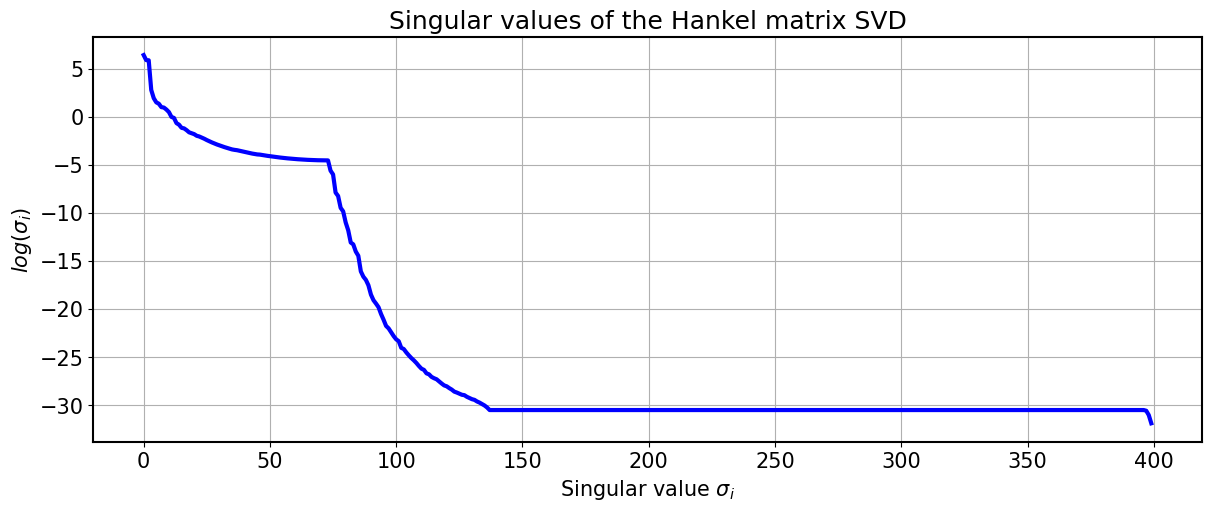

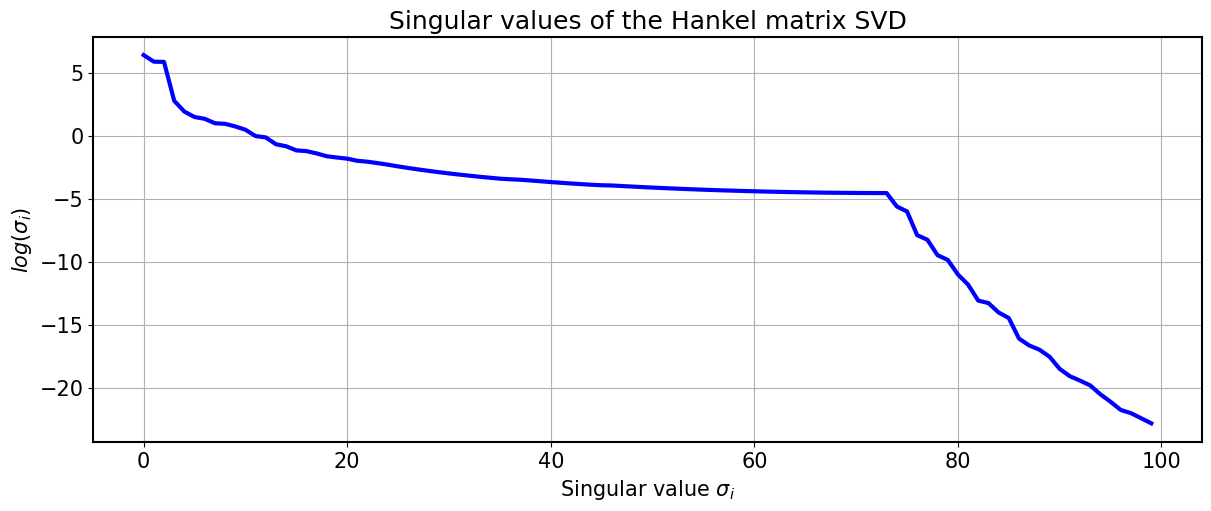

In [117]:
# In the following, pend1 --> training of A & B
#                   pend2 --> testing (trajectory simulation)

pend = pend1
horizon = np.int(len(pend.T)*.6)
model1 = HAVOK(pend.X, pend1.U)
X0 = [deg2rad(60),0]

nb_delay = [5,7,8,9,10,12,15,20,25,30]
nb_plots = len(nb_delay)
res = np.empty(shape=[2,nb_plots])

# plt.rcParams['font.size'] = 15
# fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

pend = pend2

# ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
# ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
# ax[0,0].grid()

# ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
# ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg]')
# ax[0,1].grid()

# ax[1,0].plot(pend.T[:len(pend.T)-1], pend.U, label='Input')
# ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
# ax[1,0].grid(), ax[1,0].legend(), ax[1,0].set_title('Original control input')

for i in range(nb_plots):
    tau = nb_delay[i]
    model1.HANKEL(horizon)
    model1.SVD(tau)
    model1.LS(tau)
    model1.Simulate(pend.X0, U_testing=pend.U)
    
    
#     ax[0,0].plot(pend.T[:len(pend.T)], rad2deg(model1.X_traj[0,:]), label='r = '+str(tau))
#     ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
#     ax[0,0].grid()
#     ax[0,0].legend(bbox_to_anchor=(.9, 1.3),ncol=nb_plots,fontsize=12)

#     ax[0,1].plot(pend.T[:len(pend.T)], rad2deg(model1.X_traj[1,:]), label='r = '+str(tau))
#     ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
#     ax[0,1].grid()
#     ax[0,1].legend(bbox_to_anchor=(.9, 1.35),ncol=nb_plots,fontsize=12)
    
    res[:,i] = model1.residuals
    
# ax[1,1].plot(nb_delay, np.log(res[0,:]),'-o', markersize=10, color='b', label='Position')
# ax[1,1].plot(nb_delay, np.log(res[1,:]),'-o', markersize=10, color='r', label='Velocity')
# ax[1,1].set_xlabel(r'Subspace dimension $r$'), ax[1,1].set_ylabel('Log(precision)'), ax[1,1].legend()
# ax[1,1].grid(), ax[1,1].set_title('Least square log residuals')
# ax[0,0].grid(), ax[0,1].grid()

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(12,5))
plt.plot(nb_delay, np.log(res[0,:]),'-o', markersize=10, color='b', label='Position')
plt.plot(nb_delay, np.log(res[1,:]),'-o', markersize=10, color='r', label='Velocity')
plt.xlabel(r'Subspace dimension $r$'), plt.ylabel(r'$log(\sum \epsilon_{LS}^2)$'), plt.legend(), plt.grid()
plt.title('Least square regression residuals')

fig.savefig('Images/Pend_DMD_sine.svg',format='svg',dpi=800)

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(12,5))
plt.plot(np.log(model1.sigma), markersize=10, color='b')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(12,5))
plt.plot(np.log(model1.sigma[:100]), markersize=10, color='b')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')

## LQR control of learned dynamics
### LQR rollout

(Text(0.5, 32.16699999999986, 'Horizon'),
 Text(901.3911741316984, 0.5, 'Subspace coordinate $r$'))

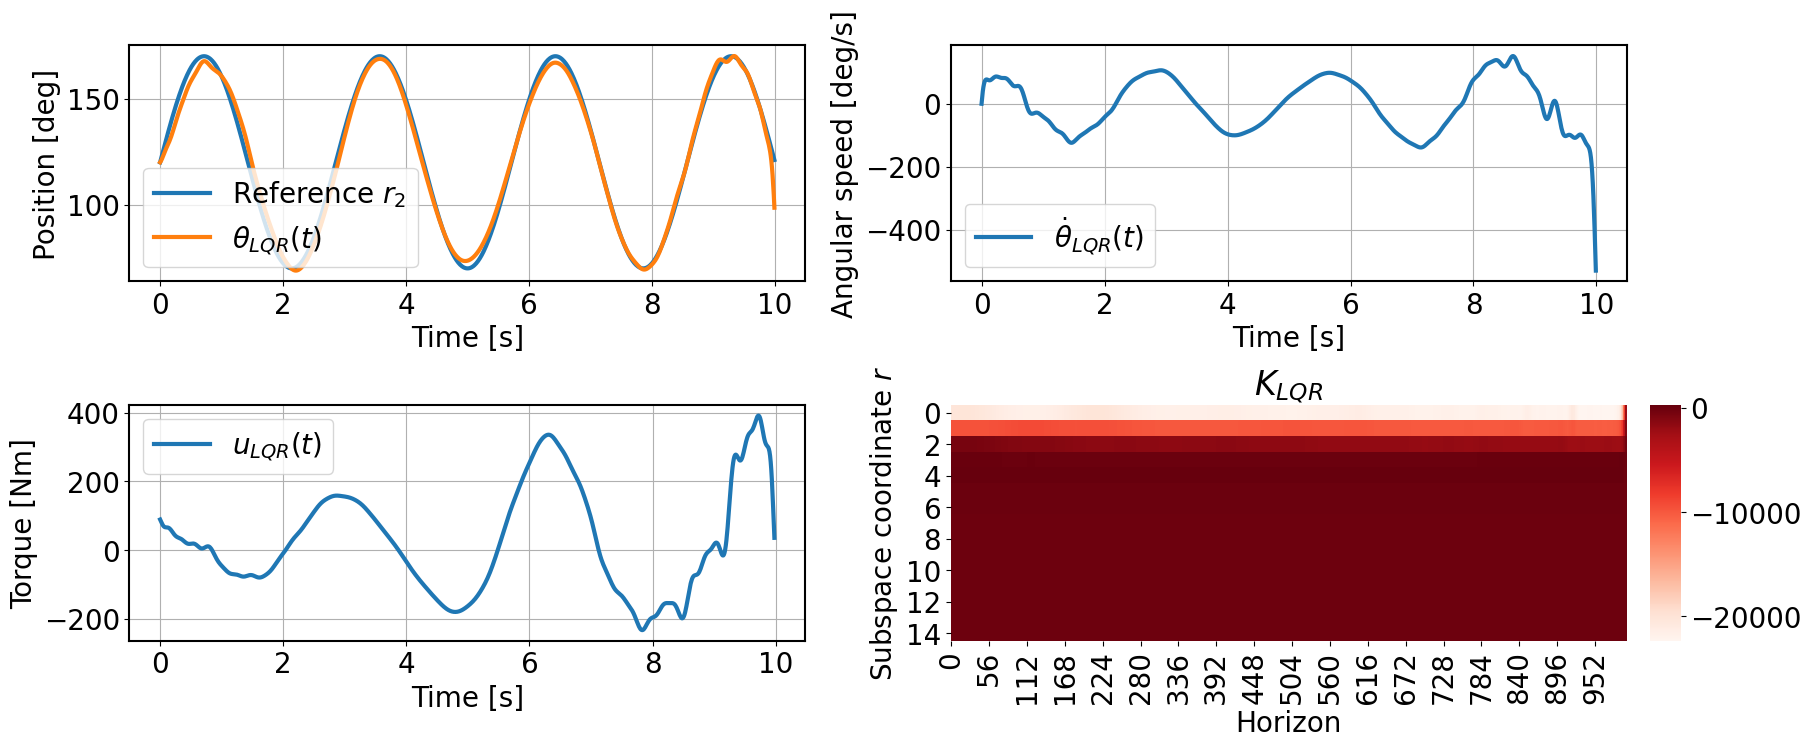

In [118]:
tau = 15
# Training
pend=pend1
model1 = HAVOK(pend.X, pend.U)
model1.HANKEL(horizon)
model1.SVD(tau)
model1.LS(tau)
# Testing
pend=pend2
model1.Simulate(pend.X0, U_testing=pend.U)
model1.ConstructLQR(x_std=1e6, u_std=0., dt=pend.dt, ref=pend.ref)
model1.LQR_simulate(pend.X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref)), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

### LQR planning for true dynamics

LQR cost :  766619366.8978816


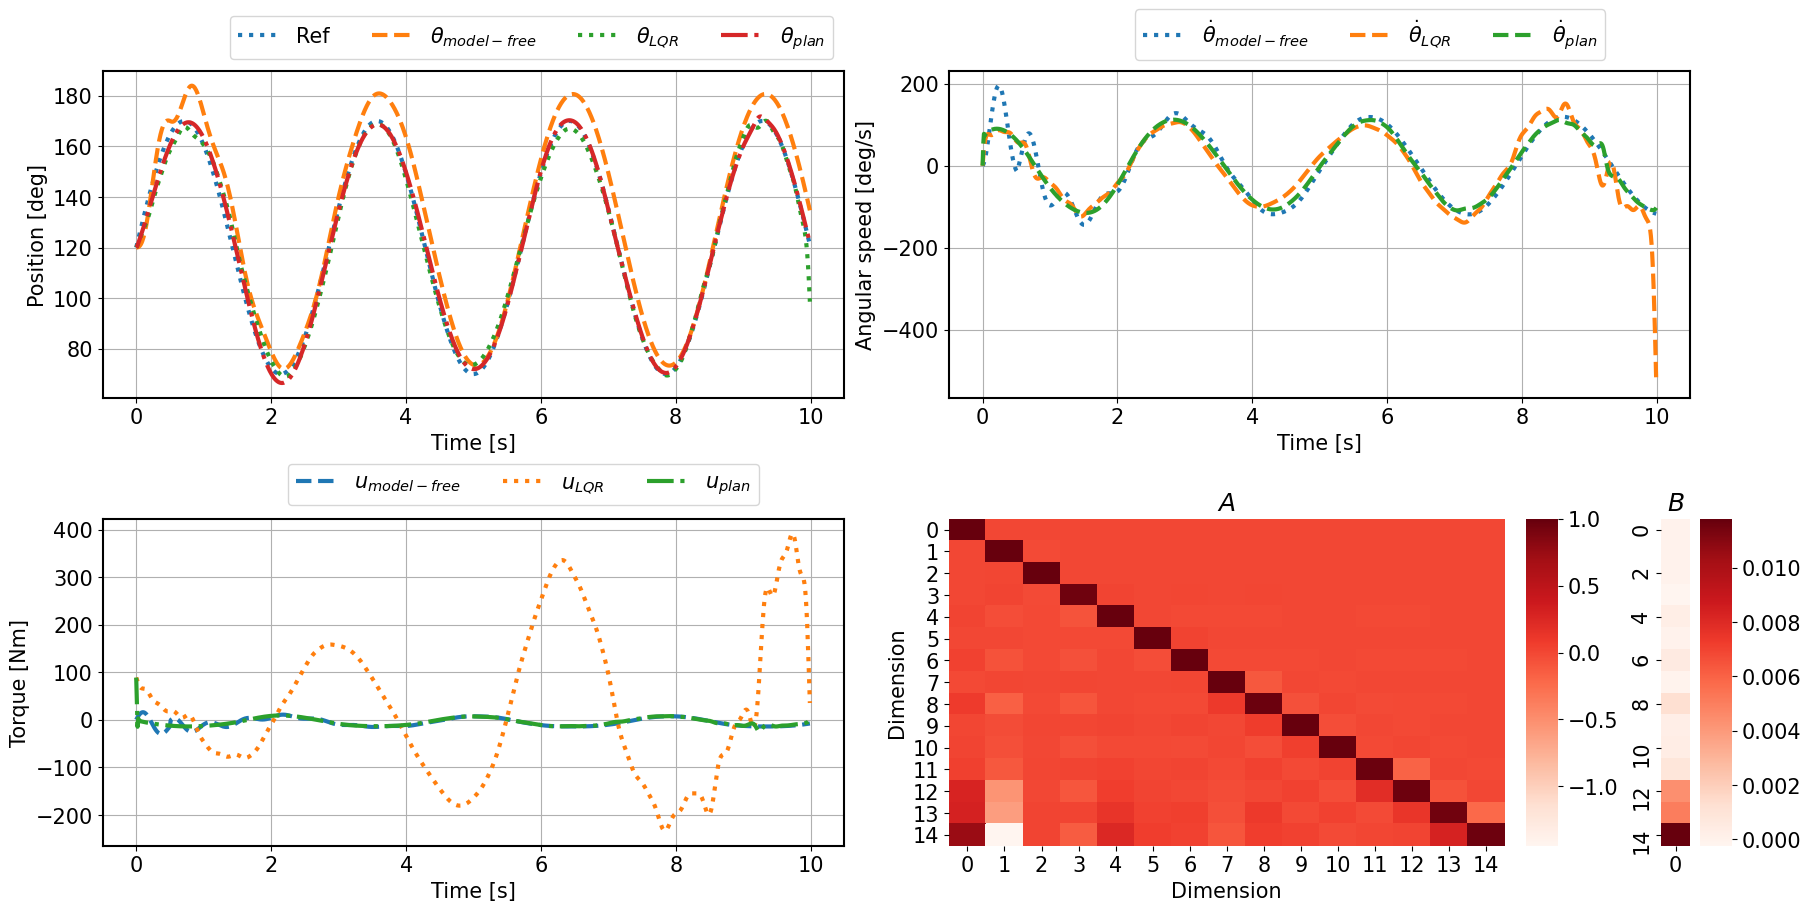

In [119]:
pend = pend2
X0 = pend.X0
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = model1.LQR.get_command(Yc[:,i],i)
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
print('LQR cost : ',model1.LQR_cost(Xc, Uc, pend.ref))
    
# Plot
plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(18,9))

gs = fig.add_gridspec(8, 8)

ax00 = fig.add_subplot(gs[0:4,0:4])
ax01 = fig.add_subplot(gs[0:4,4:8])
ax10 = fig.add_subplot(gs[4:8,0:4])
ax11_0 = fig.add_subplot(gs[4:8,4:7])
ax11_1 = fig.add_subplot(gs[4:8,7:8])

ax00.plot(pend.T, rad2deg(np.array(pend.ref)), linestyle='dotted', label='Ref')
ax00.plot(pend.T, rad2deg(pend.X[0,:]), linestyle='dashed', label=r'$\theta_{model-free}$')
ax00.plot(pend.T, rad2deg(model1.LQR_X[:,0]), linestyle=':', label=r'$\theta_{LQR}$')
ax00.plot(pend.T, rad2deg(Xc[0,:]), linestyle='dashdot', label=r"$\theta_{plan}$")
ax00.set_xlabel('Time [s]'), ax00.set_ylabel('Position [deg]')
ax00.grid()
ax00.legend(bbox_to_anchor=(1, 1.2),ncol=5)

ax01.plot(pend.T, rad2deg(pend.X[1,:]), linestyle='dotted', label=r'$\dot{\theta}_{model-free}$')
ax01.plot(pend.T, rad2deg(model1.LQR_X[:,1]), linestyle='dashed', label=r"$\dot{\theta}_{LQR}$")
ax01.plot(pend.T, rad2deg(Xc[1,:]), linestyle='dashed', label=r"$\dot{\theta}_{plan}$")
ax01.set_xlabel('Time [s]'), ax01.set_ylabel('Angular speed [deg/s]')
ax01.grid()
ax01.legend(bbox_to_anchor=(.9, 1.22),ncol=4)

ax10.plot(pend.T[:model1.N-1], pend.U, linestyle='dashed', label='$u_{model-free}$')
ax10.plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], linestyle='dotted', label='$u_{LQR}$')
ax10.plot(pend.T[:model1.N-1], Uc, linestyle='dashdot', label='$u_{plan}$')
ax10.set_xlabel('Time [s]'), ax10.set_ylabel('Torque [Nm]')
ax10.grid()
ax10.legend(bbox_to_anchor=(.9, 1.2),ncol=3)

ax11_0.set_title('$A$')
figA = snb.heatmap(model1.A,cmap='Reds',ax=ax11_0)
ax11_0.set_ylabel('Dimension'), ax11_0.set_xlabel('Dimension')

ax11_1.set_title('$B$')
figA = snb.heatmap(model1.B,cmap='Reds')

fig.savefig('Images/Pend_HAVOK_trajectories.svg',format='svg',dpi=800)

In [98]:
print('LQR cost of LQR : ',model1.LQR_cost(Xc, Uc, pend.ref))
print('LQR cost of MFC : ',model1.LQR_cost(pend.X, pend.U, pend.ref))
print('ratio = ',model1.LQR_cost(Xc, Uc, pend.ref)/model1.LQR_cost(pend.X, pend.U, pend.ref))

LQR cost of LQR :  766619366.8978816
LQR cost of MFC :  14807441014.726265
ratio =  0.0517725761078815


## (2) LQR robustness to initial condition variations

In [124]:
ic_variations = np.array([0,.01,.05,.1,.15,.2,.25,]) + 1
X0_original = 120
M = len(ic_variations)
original_cost = np.empty(shape=M)
LQR_cost = np.empty(shape=M)

# Initial condition
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
f = lambda theta, u : pend.dynamics(theta, u)

for i in range(M):
    # New IC
    pend.X0 = np.array([deg2rad(X0_original*ic_variations[i]),0])
    print(pend.X0)
    
    # LQR training
    Xc[:,0] = pend.X0
    Y0 = pinv(model1.C)@X0
    Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
    Yc[:,0] = Y0
    model1.ConstructLQR(x_std=1e6, u_std=0., dt=pend.dt, ref=pend.ref)
    
    for j in range(model1.N-1):
    
        # Original simulation
        pend.U[j] = PID(pend.X, j, pend.ref[j], 150, 3, 15, pend.dt, 50, limit=20)[0]
        pend.X[:,j+1] = RK4(pend.dynamics, pend.X[:,j], pend.U[j], pend.dt, type='controller-step-by-step')

        Uc[j] = model1.LQR.get_command(Yc[:,j],j)

        # LQR planning
        Xc[:,j+1]= RK4(f, Xc[:,j], Uc[j], t_interval, type='controller-step-by-step')
        Yc[:,j+1] = pinv(model1.C)@Xc[:,j+1]
    
    # LQR cost saving
    original_cost[i], LQR_cost[i] = model1.LQR_cost(pend.X, pend.U, pend.ref), model1.LQR_cost(Xc, Uc, pend.ref)
    
print(np.multiply(LQR_cost,np.reciprocal(original_cost)))
print(LQR_cost)
print(original_cost)

[2.0944 0.    ]
[2.11534 0.     ]
[2.19911 0.     ]
[2.30383 0.     ]
[2.40855 0.     ]
[2.51327 0.     ]
[2.61799 0.     ]
[0.05177 0.0502  0.04733 0.05145 0.06414 0.08537 0.11514]
[7.66619e+08 7.43310e+08 7.00832e+08 7.61886e+08 9.49678e+08 1.26409e+09
 1.70499e+09]
[1.48074e+10 1.48074e+10 1.48074e+10 1.48074e+10 1.48074e+10 1.48074e+10
 1.48074e+10]


## LQR testing with via-points trajectory
### (1) LQR rollout on linear dynamics

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(910.1164216564515, 0.5, 'Subspace coordinate $r$'))

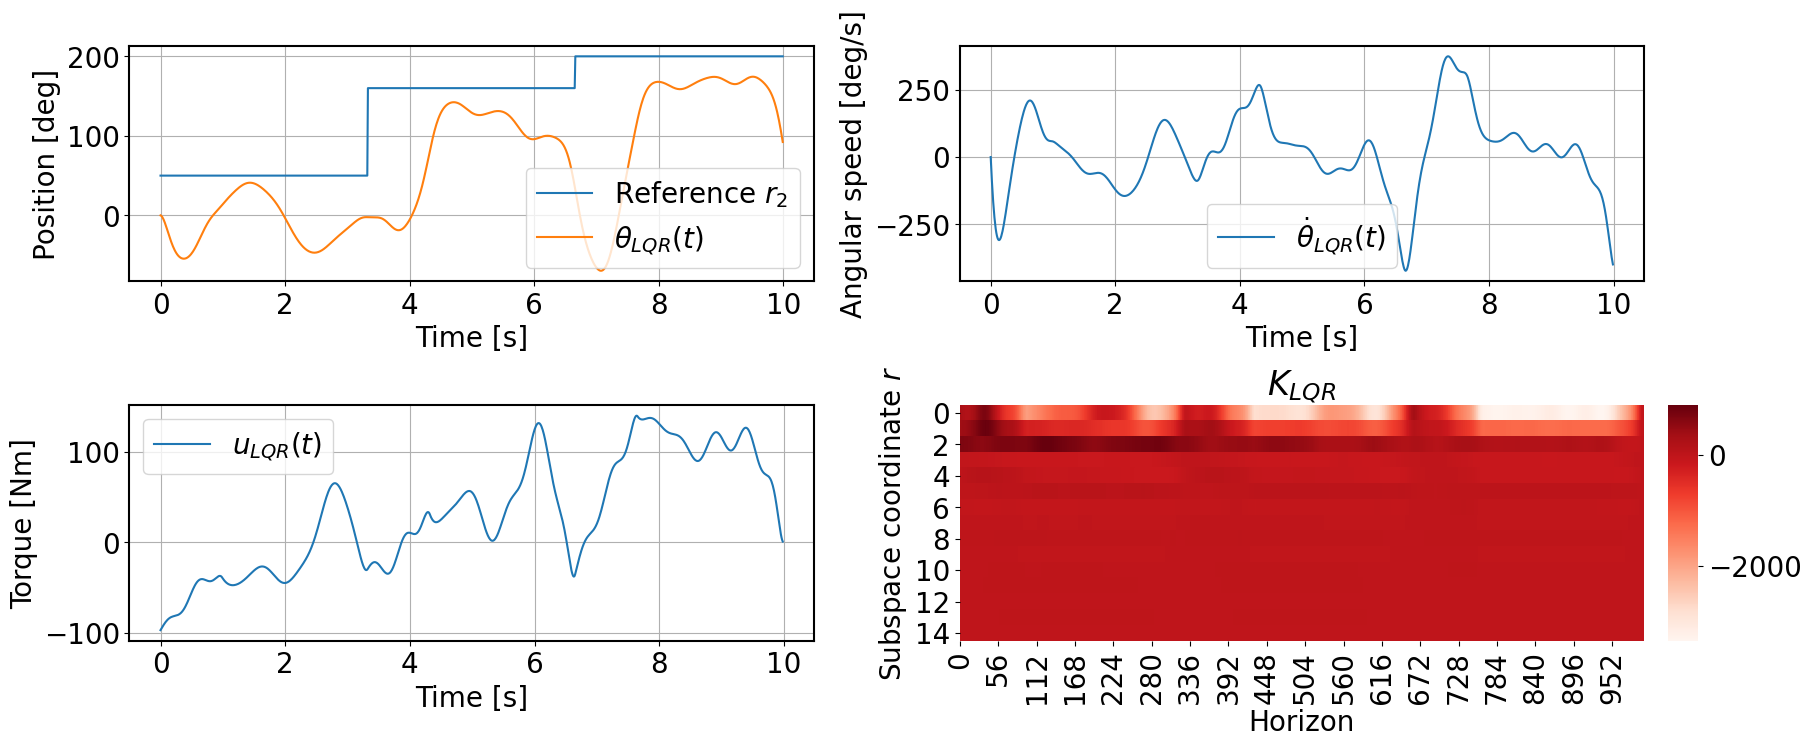

In [63]:
via_points = [deg2rad(50),deg2rad(160),deg2rad(200)]
horizon = len(pend.T)
via_time = np.int(horizon/len(via_points))
reference = np.ones(shape=[2,horizon])*via_points[len(via_points)-1]
reference[1,:] = np.zeros(shape=[horizon])
for i in range(len(via_points)-1):
    reference[0,i*via_time:(i+1)*via_time] = np.ones(shape=[via_time])*via_points[i]

precision_dwell = 100 # Number of time-steps with reduced precision
x_std, x_std_dwell, u_std = 1e6, 1, 2.
precision = np.ones(shape=[2,horizon])*x_std
precision[1,:] = np.zeros(shape=[horizon]) # Velocity precision
precision_part = np.hstack((np.ones(shape=[precision_dwell])*x_std_dwell,np.ones(shape=[via_time-precision_dwell])*x_std))
for i in range(len(via_points)):
    precision[0,i*via_time:(i+1)*via_time] = precision_part
    
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=reference.T, custom_trajectory=precision)
model1.LQR_simulate(np.array([0,0]))

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(reference[0,:]), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

### (2) LQR trajectory planning

Rollout cost is  1.9451646096915654e-159  [%] of planning cost


(Text(0.5, 32.16699999999986, 'Horizon'),
 Text(902.1125319817695, 0.5, 'Subspace coordinate $r$'))

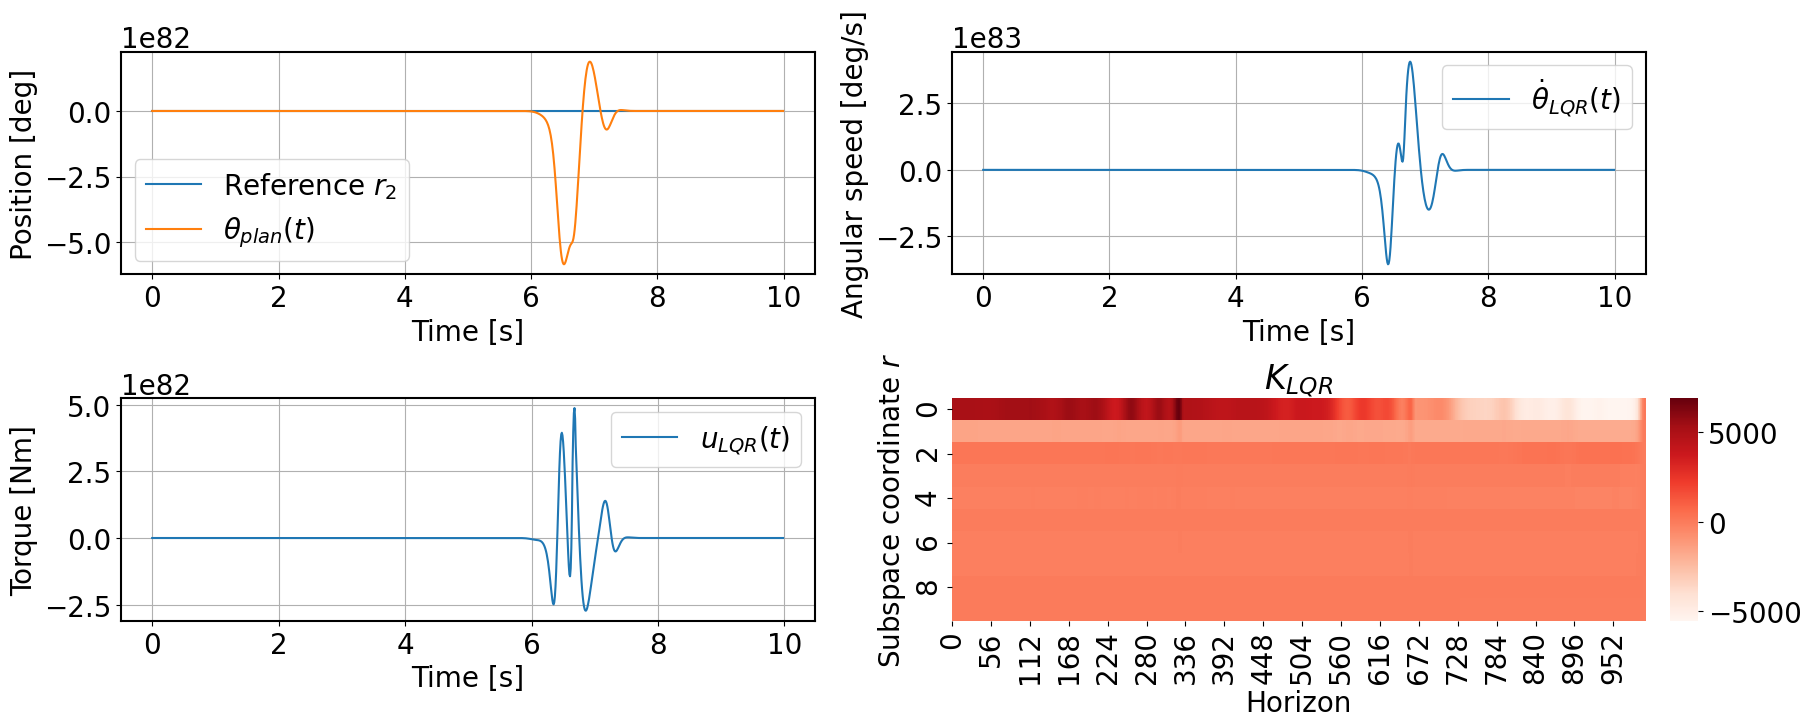

In [11]:
X0 = np.array([0,0])
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = model1.LQR.get_command(Yc[:,i],i)
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
# Evaluate LQR costs
cost_roll = model1.LQR_cost(model1.LQR_X.T,model1.LQR_U[0,:,0],reference[0,:])
cost_plan = model1.LQR_cost(Xc,Uc,reference[0,:])
print('Rollout cost is ',cost_roll/cost_plan*100,' [%] of planning cost')
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(reference[0,:]), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(Xc[0,:]), label=r"$\theta_{plan} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[1,:]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], Uc, label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

## Pendulum swing-up using LQR

(Text(0.5, 32.16699999999986, 'Horizon'),
 Text(907.1015701713034, 0.5, 'Subspace coordinate $r$'))

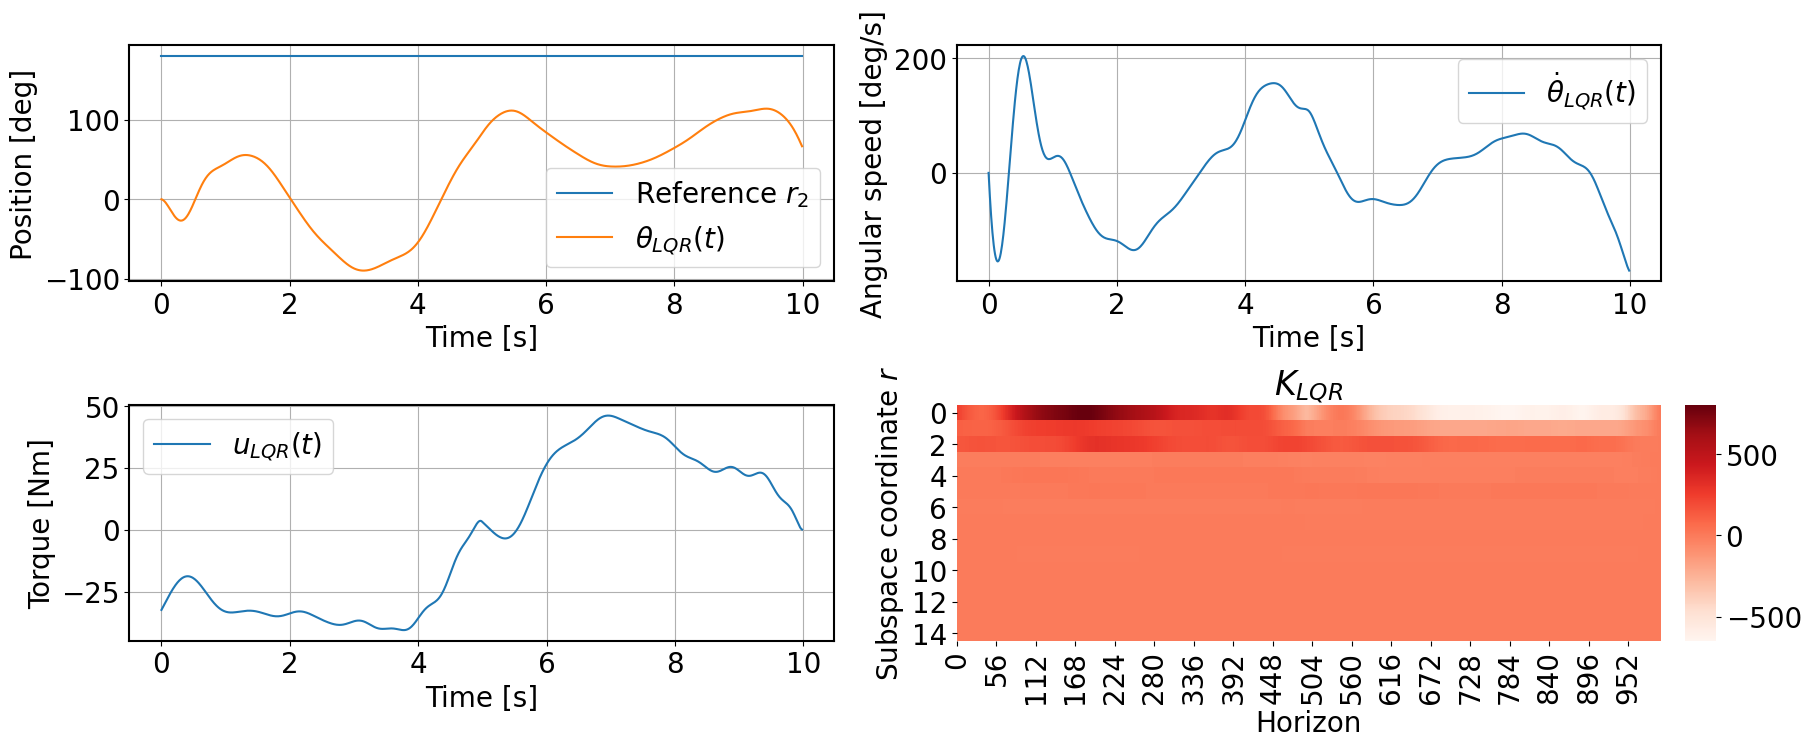

In [53]:
via_points = [deg2rad(180)]
horizon = len(pend.T)
via_time = np.int(horizon/len(via_points))
reference = np.ones(shape=[2,horizon])*via_points[len(via_points)-1]
reference[1,:] = np.zeros(shape=[horizon])
for i in range(len(via_points)-1):
    reference[0,i*via_time:(i+1)*via_time] = np.ones(shape=[via_time])*via_points[i]

precision_dwell = 500 # Number of time-steps with reduced precision
x_std, x_std_dwell, u_std = 1e6, 1e4, 3.
precision = np.ones(shape=[2,horizon])*x_std
precision[1,:] = np.zeros(shape=[horizon]) # Velocity precision
precision_part = np.hstack((np.ones(shape=[precision_dwell])*x_std_dwell,np.ones(shape=[via_time-precision_dwell])*x_std))
for i in range(len(via_points)):
    precision[0,i*via_time:(i+1)*via_time] = precision_part
    
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=reference.T, custom_trajectory=precision)
model1.LQR_simulate(np.array([0,0]))

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(reference[0,:]), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

Rollout cost is  3.6040149258617603e-06  [%] of planning cost


(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(919.6744131698881, 0.5, 'Subspace coordinate $r$'))

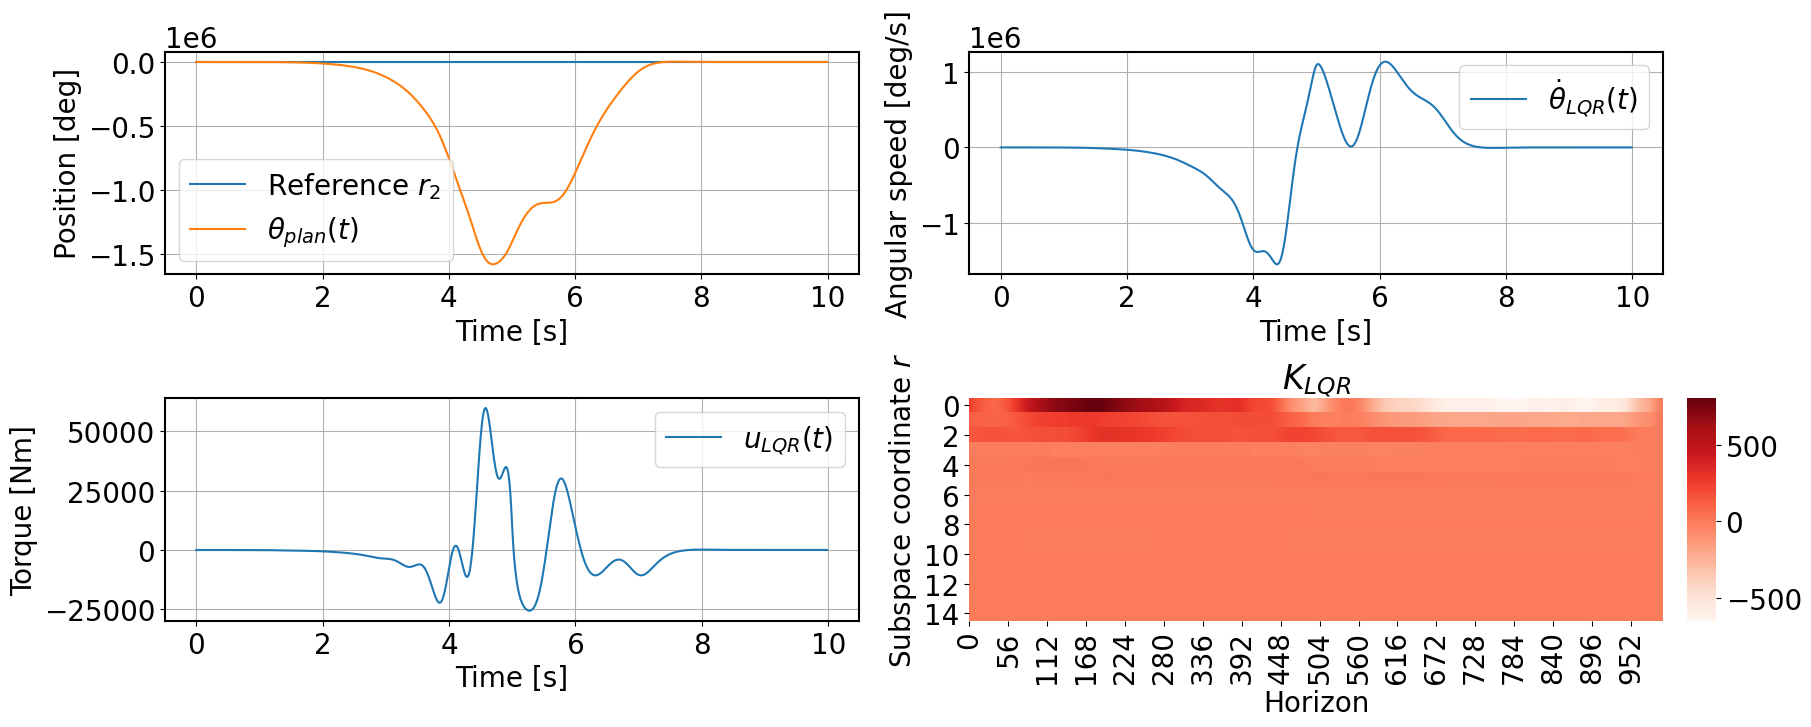

In [54]:
X0 = np.array([0,0])
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = model1.LQR.get_command(Yc[:,i],i)
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
# Evaluate LQR costs
cost_roll = model1.LQR_cost(model1.LQR_X.T,model1.LQR_U[0,:,0],reference[0,:])
cost_plan = model1.LQR_cost(Xc,Uc,reference[0,:])
print('Rollout cost is ',cost_roll/cost_plan*100,' [%] of planning cost')
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(reference[0,:]), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(Xc[0,:]), label=r"$\theta_{plan} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[1,:]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], Uc, label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')